In [4]:
from fastai.tabular.all import *
set_seed(42)

In [5]:
df = pd.read_csv('clinvar.hg19.chr21.dbnsfp.tsv', sep='\t')
mixed_type = [98,99,101,102,131,132,133,134,135,136,153,154,155,169,170,171,172,646,650,651,675,676,677,678,679,681,682,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,705,706,717,718,719,720,721,722,723,724,725,730]
for column in mixed_type:
    df.iloc[:, column] = pd.to_numeric(df.iloc[:, column], errors='coerce')
df.replace(to_replace='.', value=np.nan, inplace=True)
df.replace(regex='^[.;]+$', value=np.nan, inplace=True)
df.dropna(axis='rows', how='any', inplace=True, subset=['clinvar_clnsig'])
df.dropna(axis='columns', thresh=int(len(df.index)*0.8), inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'not_provided'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'protective'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'risk_factor'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_risk_factor'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_other,_risk_factor'].index, inplace=True)
df.replace(to_replace='Conflicting_interpretations_of_pathogenicity', value='Uncertain_significance', inplace=True)
df.replace(to_replace='Benign/Likely_benign', value='Benign', inplace=True)
df.replace(to_replace='Pathogenic/Likely_pathogenic', value='Pathogenic', inplace=True)




/tmp/ipykernel_34027/2693919677.py:1: DtypeWarning: Columns (98,99,101,102,131,132,133,134,135,136,153,154,155,169,170,171,172,646,650,651,675,676,677,678,679,681,682,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,705,706,717,718,719,720,721,722,723,724,725,730) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('clinvar.hg19.chr21.dbnsfp.tsv', sep='\t')


In [6]:
splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(df))
df_data = df.drop(columns=['clinvar_clnsig'], inplace=False)
num_cols = df_data.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_data.select_dtypes(include=[object]).columns.tolist()
df.select_dtypes(include=[np.number]).replace(to_replace=np.nan, value=0, inplace=True)
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
to = TabularPandas(df, procs=[Categorify, FillMissing, Normalize],
                   cat_names = cat_cols,
                   cont_names = num_cols,
                   y_names='clinvar_clnsig',
                    y_block=CategoryBlock(),
                   splits=splits)

In [10]:
dls = to.dataloaders(bs=1024)

In [277]:
classes = {0: 1, 1: 1, 2: 2, 3: 2, 4: 3}

class GroupLoss(nn.Module):
    def __init__(self):
        super(GroupLoss, self).__init__()

    def forward(self, inp, targ):
        sm_acts = torch.softmax(inp, dim=1)
        losses = []
        for i in range(len(targ)):
            target_class = classes[targ[i].item()]
            pred_class = sm_acts[i].argmax().item()
            if target_class != classes[pred_class]:
                losses.append(torch.log(sm_acts[i][targ[i].item()]) * 1.5)
            else:
                losses.append(torch.log(sm_acts[i][targ[i].item()]))
      
        return -torch.stack(losses).sum()


In [278]:
learn = tabular_learner(dls, metrics=accuracy, loss_func=GroupLoss())

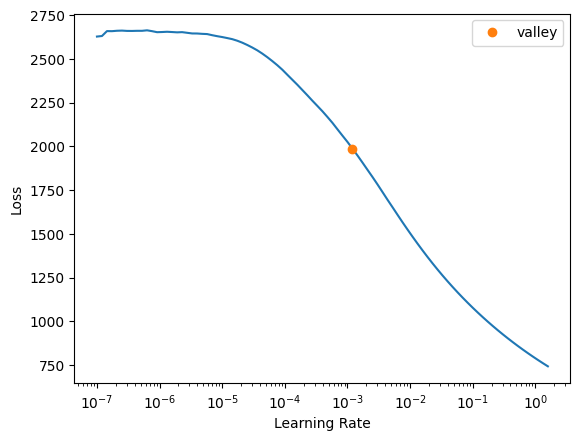

In [279]:
lr = learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,39.356434,1155.650635,0.629362,00:01
1,34.739529,1183.064575,0.610108,00:01
2,30.745285,1190.983032,0.610108,00:01
3,27.509855,1215.025879,0.598075,00:01
4,24.892498,1226.997192,0.595668,00:01
5,22.656830,1235.866455,0.598075,00:01
6,20.739948,1241.257324,0.596871,00:01
7,19.089859,1248.887085,0.594465,00:01
8,17.639097,1252.040527,0.595668,00:01
9,16.382576,1257.072632,0.595668,00:01


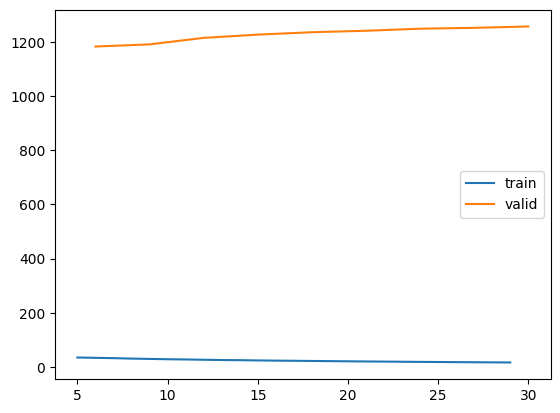

In [281]:
learn.fit(10, lr)
learn.recorder.plot_loss()

In [282]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

TypeError: GroupLoss.forward() got an unexpected keyword argument 'reduction'